In [1]:
import rhythm_regression.audio_processing as ap
from rhythm_regression.audio_processing import SAMPLING_RATE, FRAME_SIZE, HOP_LENGTH, AMPLITUDE_THRESHOLD
import rhythm_regression.midi_processing as mp
import rhythm_regression.notebook_tools as nbt
import rhythm_regression.vector_processing as vp

import librosa
import numpy as np
import matplotlib.pyplot as plt
import mido
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

ModuleNotFoundError: No module named 'librosa'

In [ ]:
samples_table = pd.read_csv('./data/Samples.csv', index_col=0)
samples_table.head()

,sample_name,file format,midi_file,tempo,in_time,dynamic,composer,recorded with,distance to mic (ft),Room,audible met,met type,player_met_aware,recorder_met_aware,correct_rhythm,notes
sample_id,,,,,,,,,,,,,,,,
1,Sample 1,m4a,Ram_8's_120bpm.mid,120,True,F,Christian Kuhlman,iphone,5,bedroom,False,metropitch,True,False,NaN,NaN
2,Sample 2,m4a,Ram_8's_120bpm.mid,120,True,F,Christian Kuhlman,iphone,5,bedroom,False,metropitch,True,False,NaN,NaN
3,Sample 3,m4a,Ram_8's_120bpm.mid,120,True,F,Christian Kuhlman,iphone,5,bedroom,False,metropitch,True,False,NaN,NaN
4,Sample 4,m4a,Ram_8's_120bpm.mid,120,True,F,Christian Kuhlman,iphone,5,bedroom,False,metropitch,True,False,NaN,NaN
5,Sample 5,m4a,Ram_8's_120bpm.mid,120,True,F,Christian Kuhlman,iphone,5,bedroom,False,metropitch,True,False,NaN,NaN


# Extra Transients

In [ ]:
#sample_name = 'Sample 9.m4a'
sample_name = 'Sample 86.m4a'
audio, sampling_rate = librosa.load(f'./data/audio/{sample_name}')
transient_vector = ap.transients(audio, SAMPLING_RATE, FRAME_SIZE, HOP_LENGTH, AMPLITUDE_THRESHOLD)

#midi_name = './data/midi/Ram_8\'s_135bpm.mid'
midi_name = './data/midi/CSU_Green_Beat_(Top_to_17)_110bpm.mid'
midi = mido.MidiFile(midi_name)
midi_vector = mp.get_midi_vector(midi)

bpm = mp.get_bpm(midi)

transient_vector, midi_vector, bpm

(array([ 8.        ,  8.12698413,  8.26984127,  8.3968254 ,  8.53968254,
         8.68253968,  8.95238095,  9.0952381 ,  9.23809524,  9.49206349,
         9.63492063,  9.77777778,  9.84126984,  9.93650794, 10.03174603,
        10.17460317, 10.23809524, 10.31746032, 10.38095238, 10.46031746,
        10.53968254, 10.6031746 , 10.66666667, 10.74603175, 11.        ,
        11.26984127, 11.41269841, 11.49206349, 11.57142857, 11.68253968,
        11.82539683, 11.88888889, 11.98412698, 12.11111111, 12.17460317,
        12.25396825, 12.38095238, 12.53968254, 12.68253968, 12.80952381,
        13.04761905, 13.20634921, 13.44444444, 13.6031746 , 13.66666667,
        13.76190476, 13.87301587, 14.01587302, 14.07936508, 14.15873016,
        14.23809524, 14.31746032, 14.42857143, 14.47619048, 14.57142857,
        14.63492063, 14.71428571, 14.77777778, 14.85714286, 14.96825397,
        15.11111111, 15.34920635, 15.42857143, 15.49206349, 15.57142857,
        15.65079365, 15.77777778, 15.92063492, 16.0

In [ ]:
len(transient_vector), len(midi_vector)

(229, 228)

<AxesSubplot:xlabel='Time (s)'>

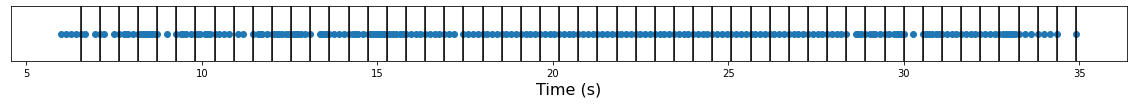

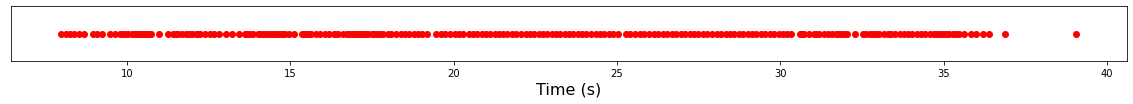

In [ ]:
time_range = None
nbt.plot_midi_vector(midi_vector, bpm, time_range=time_range, units='s', figsize=(20,1))
nbt.plot_midi_vector(transient_vector, bpm, time_range=time_range, units='s', figsize=(20,1), color='red', draw_beats=False)

In [ ]:
def delete_transients(t, m):

    min_tae = np.inf
    q_best = None

    if m.min() > 0:
        m = m - m.min()

    for q in range(0, len(t) - len(m) + 1):
        tae = np.abs((m+t[q]) - t[q : q+len(m)]).sum()

        if tae < min_tae:  # less than gives us the first occurance, because solutions are non-unique
            min_tae = tae
            q_best = q

    m_star = m + t[q_best]
    t_star = [None] * len(m_star)

    # each midi note selects its nearest transient
    claimed_indices = []
    for i in range(len(m_star)):
        # we only have to check a neighborhood of 3 since m_star is shifted and both lists are sorted
        left_index = max(q_best + i - 1, 0)
        middle_index = q_best + i
        right_index = min(q_best + i + 1, len(t)-1)

        neighbors = [left_index, middle_index, right_index]
        #neighbors.sort(key=lambda index: abs(m_star[i] - t[index]))
        neighbors.sort(key=lambda index: vp.I_heuristic(m_star, t, i, index))
        for j in range(len(neighbors)):
            if neighbors[j] not in claimed_indices:
                nearest_transient = neighbors[j]
                claimed_indices.append(neighbors[j])
                break

        t_star[i] = t[nearest_transient]

    return np.array(t_star)


def explain_deletions(t, m, time_range=None, reversed=False):

    min_tae = np.inf
    q_best = None

    if m.min() > 0:
        m = m - m.min()

    for q in range(0, len(t) - len(m) + 1):
        tae = np.abs((m+t[q]) - t[q : q+len(m)]).sum()

        if tae < min_tae:  # less than gives us the first occurance, because solutions are non-unique
            min_tae = tae
            q_best = q

    m_star = m + t[q_best]
    t_star = [None] * len(m_star)

    m_color = 'red' if reversed else 'C0'
    t_color = 'C0' if reversed else 'red'
    m_y = 0.15 if reversed else 0.85
    t_y = 0.85 if reversed else 0.15
    axs = nbt.plot_midi_vector(m_star, bpm, time_range=time_range, units='s', figsize=(20,1), y_level=m_y, draw_beats=False, color=m_color)
    axs = nbt.plot_midi_vector(t, bpm, time_range=time_range, units='s', figsize=(20,1), color=t_color, draw_beats=False, axs=axs, y_level=t_y)

    # each midi note selects its nearest transient
    claimed_indices = []
    for i in range(len(m_star)):
        # we only have to check a neighborhood of 3 since m_star is shifted and both lists are sorted
        left_index = max(q_best + i - 1, 0)
        middle_index = q_best + i
        right_index = min(q_best + i + 1, len(t)-1)

        neighbors = [left_index, middle_index, right_index]
        #neighbors.sort(key=lambda index: abs(m_star[i] - t[index]))
        neighbors.sort(key=lambda index: vp.I_heuristic(m_star, t, i, index))
        for j in range(len(neighbors)):
            if neighbors[j] not in claimed_indices:
                nearest_transient = neighbors[j]
                claimed_indices.append(neighbors[j])
                
                if time_range is None:
                    in_time_range = True
                else:
                    in_time_range = (time_range[0] <= m_star[i]) and (m_star[i] <= time_range[1]) and (time_range[0] <= t[nearest_transient]) and (t[nearest_transient] <= time_range[1])
                if in_time_range:
                    #axs.plot([m_star[i], t[nearest_transient]], [0.85, 0.15], color='k')
                    dy = t_y - m_y -0.1 if reversed else t_y - m_y + 0.1
                    dx = t[nearest_transient] - m_star[i]
                    axs.arrow(m_star[i], m_y, dx, dy, width=0.005, head_width=0.05, length_includes_head=True, color='k') 
                break

    return axs
            
            

In [ ]:
t_star = delete_transients(transient_vector, midi_vector)
print(len(t_star))
t_star

228


array([ 8.        ,  8.12698413,  8.26984127,  8.3968254 ,  8.53968254,
        8.68253968,  8.95238095,  9.0952381 ,  9.23809524,  9.49206349,
        9.63492063,  9.77777778,  9.84126984,  9.93650794, 10.03174603,
       10.17460317, 10.23809524, 10.31746032, 10.38095238, 10.46031746,
       10.53968254, 10.6031746 , 10.66666667, 10.74603175, 11.        ,
       11.26984127, 11.41269841, 11.49206349, 11.57142857, 11.68253968,
       11.82539683, 11.88888889, 11.98412698, 12.11111111, 12.17460317,
       12.25396825, 12.38095238, 12.53968254, 12.68253968, 12.80952381,
       13.04761905, 13.20634921, 13.44444444, 13.6031746 , 13.66666667,
       13.76190476, 13.87301587, 14.01587302, 14.07936508, 14.15873016,
       14.23809524, 14.31746032, 14.42857143, 14.47619048, 14.57142857,
       14.63492063, 14.71428571, 14.77777778, 14.85714286, 14.96825397,
       15.11111111, 15.34920635, 15.42857143, 15.49206349, 15.57142857,
       15.65079365, 15.77777778, 15.92063492, 16.06349206, 16.17

Text(0.5, 1.0, 'Bad Transient Deletion (Sample 86.m4a)')

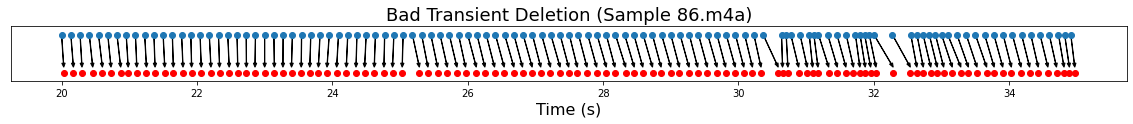

In [ ]:
explain_deletions(transient_vector, midi_vector, time_range=(20,35))
plt.title(f'Bad Transient Deletion ({sample_name})', fontsize=18)

# Missing Transients

In [ ]:
sample_name = 'Sample 69.m4a'
audio, sampling_rate = librosa.load(f'./data/audio/{sample_name}')
transient_vector = ap.transients(audio, SAMPLING_RATE, FRAME_SIZE, HOP_LENGTH, AMPLITUDE_THRESHOLD)

midi_name = './data/midi/CAM_Rolls_(Edited)_140bpm.mid'
midi = mido.MidiFile(midi_name)
midi_vector = mp.get_midi_vector(midi)

bpm = mp.get_bpm(midi)

transient_vector, midi_vector, bpm

(array([ 3.19047619,  3.49206349,  3.77777778,  4.07936508,  4.36507937,
         4.66666667,  4.93650794,  5.22222222,  5.52380952,  5.80952381,
         6.0952381 ,  6.36507937,  6.63492063,  6.92063492,  7.22222222,
         7.50793651,  7.79365079,  8.0952381 ,  8.38095238,  8.66666667,
         8.93650794,  9.22222222,  9.50793651,  9.80952381, 10.0952381 ,
        10.25396825, 10.3968254 , 10.52380952, 10.66666667, 10.79365079,
        10.93650794, 11.        , 11.07936508, 11.22222222, 11.36507937,
        11.42857143, 11.50793651, 11.65079365, 11.79365079, 11.92063492,
        12.06349206, 12.20634921, 12.34920635, 12.47619048, 12.61904762,
        12.76190476, 12.82539683, 12.9047619 , 13.04761905, 13.17460317,
        13.25396825, 13.33333333, 13.49206349, 13.61904762, 13.76190476,
        13.9047619 , 14.04761905, 14.19047619, 14.33333333, 14.47619048,
        14.6031746 , 14.68253968, 14.76190476, 14.9047619 , 15.04761905,
        15.11111111, 15.19047619, 15.34920635, 15.4

In [ ]:
len(transient_vector), len(midi_vector)

(288, 291)

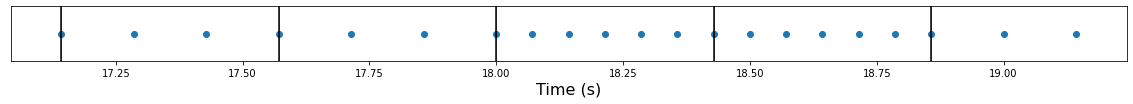

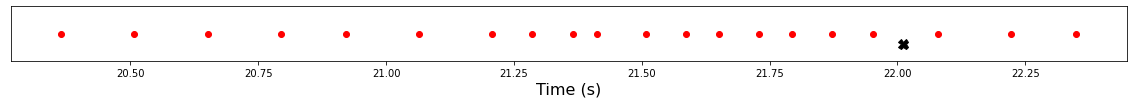

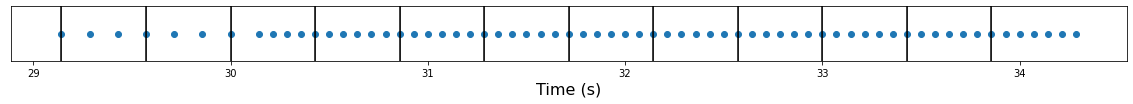

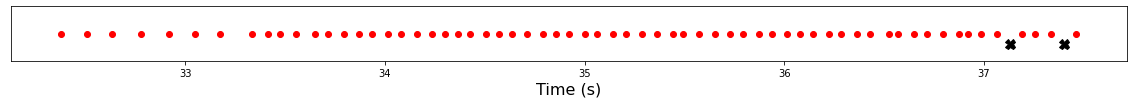

In [ ]:
nbt.plot_midi_vector(midi_vector, bpm, time_range=(17.1,19.2), units='s', figsize=(20,1))
axs = nbt.plot_midi_vector(transient_vector, bpm, time_range=(20.35,22.4), units='s', figsize=(20,1), color='red', draw_beats=False)
axs.plot([22.01], [0.3], 'Xk', markersize=10)

nbt.plot_midi_vector(midi_vector, bpm, time_range=(29.1,45), units='s', figsize=(20,1))
axs = nbt.plot_midi_vector(transient_vector, bpm, time_range=(32.35,45), units='s', figsize=(20,1), color='red', draw_beats=False)
axs.plot([37.13, 37.4], [0.3, 0.3], 'Xk', markersize=10)

In [ ]:
def add_nan_transients(t, m):
    m_star = delete_transients(m,t - t.min())
    m_star_set = set(m_star)  # used for O(1) "in" operator on next line.
    deleted_indices = [i for i in range(len(m)) if m[i] not in m_star_set]

    t_star = t.copy()
    for i in deleted_indices:
        if i >= len(t_star):
            t_star = np.append(t_star, np.nan)
        else:
            t_star = np.insert(t_star, i, np.nan)
    
    return t_star

def explain_insertions(t, m, time_range=None):
    explain_deletions(m,t - t.min(), time_range, reversed=True)
    t_star = add_nan_transients(t, m)
    
    predictions = np.array([m[i] for i in np.argwhere(np.isnan(t_star)).flatten().tolist()])
    predictions = predictions[(time_range[0] <= predictions) & (predictions <= time_range[1])]
    plt.plot(predictions, [0.65]*len(predictions), '*m', markersize=10)
    return plt.gca()

In [ ]:
t_star = add_nan_transients(transient_vector, midi_vector)
t_star

array([ 3.19047619,  3.49206349,  3.77777778,  4.07936508,  4.36507937,
        4.66666667,  4.93650794,  5.22222222,  5.52380952,  5.80952381,
        6.0952381 ,  6.36507937,  6.63492063,  6.92063492,  7.22222222,
        7.50793651,  7.79365079,  8.0952381 ,  8.38095238,  8.66666667,
        8.93650794,  9.22222222,  9.50793651,  9.80952381, 10.0952381 ,
       10.25396825, 10.3968254 , 10.52380952, 10.66666667, 10.79365079,
       10.93650794, 11.        , 11.07936508, 11.22222222, 11.36507937,
       11.42857143, 11.50793651, 11.65079365, 11.79365079, 11.92063492,
       12.06349206, 12.20634921, 12.34920635, 12.47619048, 12.61904762,
       12.76190476, 12.82539683, 12.9047619 , 13.04761905, 13.17460317,
       13.25396825, 13.33333333, 13.49206349, 13.61904762, 13.76190476,
       13.9047619 , 14.04761905, 14.19047619, 14.33333333, 14.47619048,
       14.6031746 , 14.68253968, 14.76190476, 14.9047619 , 15.04761905,
       15.11111111, 15.19047619, 15.34920635, 15.47619048, 15.63

In [ ]:
np.argwhere(np.isnan(t_star)).flatten().tolist()

[125, 289, 290]

In [ ]:
len(t_star), len(midi_vector)

(291, 291)

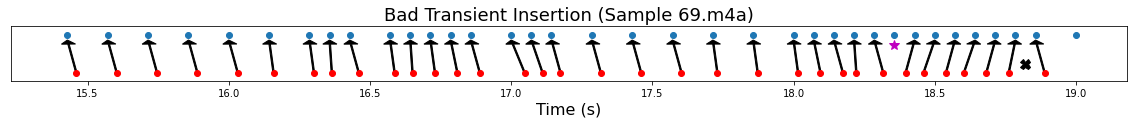

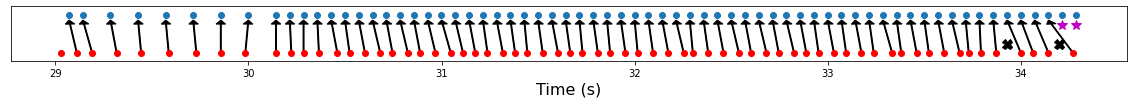

In [ ]:
axs = explain_insertions(transient_vector, midi_vector, time_range=(15.4,19))
axs.plot([18.82], [0.3], 'Xk', markersize=10)
plt.title(f'Bad Transient Insertion ({sample_name})', fontsize=18)
axs = explain_insertions(transient_vector, midi_vector, time_range=(29,45))
axs.plot([33.93, 34.2], [0.3, 0.3], 'Xk', markersize=10)